In [ ]:
#Importing essential libraries
%tensorflow_version 1.x
import tensorflow as tf
import random
import numpy as np
from google.colab import files
import pandas as pd
from tqdm import tqdm
import os
import math
import shutil
import pathlib
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image


TensorFlow 1.x selected.


In [ ]:
#Checking for gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
1.15.2


In [ ]:
#Fixing python random seed
random.seed(42)
#fixing numpy random seed
np.random.seed(21)
#fixing tensorflow random seed
tf.compat.v1.random.set_random_seed(42)

In [ ]:
#Downloading dataset from kaggle
def download_dataset_from_kaggle() :
  '''
  This function downloads the German traffic sign
  dataset from kaggle and stores it in temporary
  session memory of google colab and unzips it.
  '''
  #Upload the kaggle api token
  print('Please upload the kaggle api token :')
  files.upload() #this will prompt you to update the json
  !pip install -q kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !ls ~/.kaggle
  !chmod 600 /root/.kaggle/kaggle.json  # set permission

  #Downloading and unzipping the dataset
  !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
  !unzip -q /content/gtsrb-german-traffic-sign.zip -d Data
download_dataset_from_kaggle()

Please upload the kaggle api token :


Saving kaggle.json to kaggle.json
kaggle.json
 99% 605M/612M [00:19<00:00, 31.3MB/s]
100% 612M/612M [00:19<00:00, 32.2MB/s]


### Train-Validation Split :

In [ ]:
#Run this only once
#Creating validation directory
val_dir = "/content/Data/Validation"
os.mkdir(val_dir)

n_classes = 43
train_dir = "/content/Data/Train{0}"

#Moving files from train to validation directory
for n in tqdm(range(n_classes)) :
  path = os.path.join(val_dir, str(n))
  os.mkdir(path)
  src_path = train_dir.format('/' + str(n))
  files = os.listdir(src_path)
  rand_idx = random.sample(range(len(files)), math.ceil(len(files)/10))
  for idx in rand_idx :
    src = src_path + "/" + files[idx]
    shutil.move(src, path)

100%|██████████| 43/43 [00:00<00:00, 259.98it/s]


In [ ]:
#Setting up variables
train_path = "/content/Data/Train"         #Train dataset path
val_path = "/content/Data/Validation"      #Validation dataset path

In [ ]:
#Path to train and validation datasets
data_root_train = pathlib.Path(train_path)
data_root_val = pathlib.Path(val_path)

#Getting paths to all the images in train and validation sets
all_image_paths_train = list(data_root_train.glob('*/*'))
all_image_paths_train = [str(path) for path in all_image_paths_train]

all_image_paths_val = list(data_root_val.glob('*/*'))
all_image_paths_val = [str(path) for path in all_image_paths_val]

#Counting number of images in each sets
image_count_train = len(all_image_paths_train)
image_count_val = len(all_image_paths_val)

In [ ]:
df_train = pd.read_csv("/content/Data/Train.csv")
train_idx_list = []
val_idx_list = []
for path_tr in tqdm(all_image_paths_train) :
  train_idx_list.append(df_train[df_train['Path'] == path_tr[14 : ]].index[0])
for path_val in tqdm(all_image_paths_val) :
  path_val = "Train/" + path_val[25:]
  val_idx_list.append(df_train[df_train['Path'] == path_val].index[0])
new_df_train = pd.DataFrame()
new_df_val = pd.DataFrame()
new_df_train = new_df_train.append(df_train.iloc[train_idx_list], ignore_index = True)
new_df_val = new_df_val.append(df_train.iloc[val_idx_list], ignore_index = True)

100%|██████████| 3921/3921 [00:09<00:00, 420.04it/s]


In [ ]:
!mkdir "/content/Desktop"
%cd "/content/Desktop"
!git clone https://github.com/tensorflow/models.git

/content/Desktop
Cloning into 'models'...
remote: Enumerating objects: 38161, done.
remote: Total 38161 (delta 0), reused 0 (delta 0), pack-reused 38161
Receiving objects: 100% (38161/38161), 544.47 MiB | 21.81 MiB/s, done.
Resolving deltas: 100% (25575/25575), done.


In [ ]:
!mkdir "/content/Desktop/models/research/object_detection/images"
!mkdir "/content/Desktop/models/research/object_detection/training"

In [ ]:
new_df_train = new_df_train[['Path', 'Width', 'Height', 'ClassId', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']]

for itr in tqdm(range(new_df_train.shape[0])) :
  new_df_train.iloc[itr, 0] = "/content/Desktop/models/research/object_detection/images/" + new_df_train.iloc[itr, 0]
  new_df_train.iloc[itr, 3] += 1

new_df_train = new_df_train.rename(columns={'Path' : 'filename',
                         'Width' : 'width',
                         'Height' : 'height',
                         'ClassId' : 'class',
                         'Roi.X1' : 'xmin', 
                         'Roi.Y1' : 'ymin',
                         'Roi.X2' : 'xmax',
                         'Roi.Y2' : 'ymax'})

new_df_train.to_csv("/content/Desktop/models/research/object_detection/data/train_labels.csv")

100%|██████████| 35288/35288 [01:01<00:00, 577.46it/s]


In [ ]:
new_df_val = new_df_val[['Path', 'Width', 'Height', 'ClassId', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']]

for itr in tqdm(range(new_df_val.shape[0])) :
  new_df_val.iloc[itr, 0] = "/content/Desktop/models/research/object_detection/images/Validation" + new_df_val.iloc[itr, 0][5:]
  new_df_val.iloc[itr, 3] += 1

new_df_val = new_df_val.rename(columns={'Path' : 'filename',
                         'Width' : 'width',
                         'Height' : 'height',
                         'ClassId' : 'class',
                         'Roi.X1' : 'xmin', 
                         'Roi.Y1' : 'ymin',
                         'Roi.X2' : 'xmax',
                         'Roi.Y2' : 'ymax'})

new_df_val.to_csv("/content/Desktop/models/research/object_detection/data/validation_labels.csv")

100%|██████████| 3921/3921 [00:03<00:00, 1177.68it/s]


In [ ]:
test_df = pd.read_csv("/content/Data/Test.csv")

test_df = test_df[['Path', 'Width', 'Height', 'ClassId', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']]

for itr in tqdm(range(test_df.shape[0])) :
  test_df.iloc[itr, 0] = "/content/Desktop/models/research/object_detection/images/" + test_df.iloc[itr, 0]
  test_df.iloc[itr, 3] += 1

test_df = test_df.rename(columns={'Path' : 'filename',
                         'Width' : 'width',
                         'Height' : 'height',
                         'ClassId' : 'class',
                         'Roi.X1' : 'xmin', 
                         'Roi.Y1' : 'ymin',
                         'Roi.X2' : 'xmax',
                         'Roi.Y2' : 'ymax'})

test_df.to_csv("/content/Desktop/models/research/object_detection/data/test_labels.csv")

100%|██████████| 12630/12630 [00:12<00:00, 1026.97it/s]


In [ ]:
!mv "/content/Data/Train" "/content/Desktop/models/research/object_detection/images/"
!mv "/content/Data/Validation" "/content/Desktop/models/research/object_detection/images/"
!mv "/content/Data/Test" "/content/Desktop/models/research/object_detection/images/"

In [ ]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.17-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 33 not upgraded.
Need to get 1,818 kB of archives.
After this operation, 7,685 kB of additional disk space will be used.
Get:1 htt

In [ ]:
%cd "/content/Desktop/models/research"
!protoc object_detection/protos/*.proto --python_out=.

/content/Desktop/models/research
object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [ ]:
os.environ['PYTHONPATH'] += ':/content/Desktop/models/research/:/content/Desktop/models/research/slim'

In [ ]:
!python setup.py build
!python setup.py install

running build
running build_py
creating build
creating build/lib
creating build/lib/object_detection
copying object_detection/exporter.py -> build/lib/object_detection
copying object_detection/model_main_tf2.py -> build/lib/object_detection
copying object_detection/export_inference_graph.py -> build/lib/object_detection
copying object_detection/model_main.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph_lib.py -> build/lib/object_detection
copying object_detection/__init__.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph_lib_tf1_test.py -> build/lib/object_detection
copying object_detection/inputs.py -> build/lib/object_detection
copying object_detection/model_lib_tf1_test.py -> build/lib/object_detection
copying object_detection/eval_util_test.py -> build/lib/object_detection
copying object_detection/model_lib.py -> build/lib/object_detection
copying object_detection/exporter_lib_v2.py -> build/lib/object_detection
copy

In [ ]:
!pip install tf_slim
%cd /content/Desktop/models/research/object_detection/builders/
!python model_builder_test.py

### Upload following files into their respective directories before moving forward :

*   generate_tfrecord.py in object_detection folder.
*   label_map.pbtxt in training folder.
*   config file in training folder.



In [ ]:
%cd "/content/Desktop/models/research/object_detection"
!python generate_tfrecord.py --label='GTSRB' --csv_input=data/train_labels.csv --img_path=images/Train  --output_path=training/train.record
!python generate_tfrecord.py --label='GTSRB' --csv_input=data/validation_labels.csv --img_path=images/Validation  --output_path=training/validation.record
!python generate_tfrecord.py --label='GTSRB' --csv_input=data/test_labels.csv --img_path=images/Test  --output_path=training/test.record

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_2018_01_28.tar.gz
!tar -xvf faster_rcnn_resnet101_coco_2018_01_28.tar.gz

In [ ]:
!mv "/content/Desktop/models/research/object_detection/legacy/train.py" "/content/Desktop/models/research/object_detection/"
!mv "/content/Desktop/models/research/object_detection/legacy/eval.py" "/content/Desktop/models/research/object_detection/"

In [ ]:
!python train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/faster_rcnn_resnet101.config

In [ ]:
%load_ext tensorboard
%tensorboard --logdir training/

In [ ]:
!python export_inference_graph.py --input_type image_tensor --pipeline_config_path training/faster_rcnn_resnet101.config --trained_checkpoint_prefix training/model.ckpt-3000 --output_directory trained_inference_graph/

In [ ]:
!zip -r GTSRB_exp_graph.zip trained_inference_graph

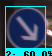

[2]




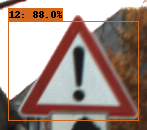

[12]




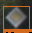

[12]




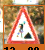

[12]




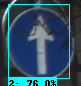

[2]




In [ ]:
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
### Model preparation variable
MODEL_NAME = 'trained_inference_graph'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training/label_map.pbtxt'
NUM_CLASSES = 1 #remember number of objects you are training? cool.

### Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

###Loading label map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### Load image into numpy function
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

###STATING THE PATH TO IMAGES TO BE TESTED
PATH_TO_TEST_IMAGES_DIR = 'test_images/'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.png'.format(i)) for i in range(1, 10) ]
TEST_IMAGE_PATHS = list(test_df.iloc[5:10, 0])
IMAGE_SIZE = (256, 256)
### Function to run inference on a single image which will later be used in an iteration
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

### To iterate on each image in the test image path defined 
### NB define the range of numbers and let it match the number of imAGES IN TEST FOLDER +1
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=1)
  display(Image.fromarray(image_np))
  print(output_dict['detection_classes'])
  print("\n")

In [ ]:
test_df.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/Desktop/models/research/object_detect...,53,54,17,6,5,48,49
1,/content/Desktop/models/research/object_detect...,42,45,2,5,5,36,40
2,/content/Desktop/models/research/object_detect...,48,52,39,6,6,43,47
3,/content/Desktop/models/research/object_detect...,27,29,34,5,5,22,24
4,/content/Desktop/models/research/object_detect...,60,57,12,5,5,55,52
5,/content/Desktop/models/research/object_detect...,52,56,39,5,5,47,51
6,/content/Desktop/models/research/object_detect...,147,130,19,12,12,135,119
7,/content/Desktop/models/research/object_detect...,32,33,13,5,5,26,28
8,/content/Desktop/models/research/object_detect...,45,50,26,6,5,40,45
9,/content/Desktop/models/research/object_detect...,81,86,36,7,7,74,79
